In [6]:
from keras.layers import Input, Dense 
# from keras.layers import Dropout, BatchNormalization, Reshape
from keras.models import Model
#from keras.regularizers import l2
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
# from sklearn.model_selection import train_test_split
import pickle
import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt
import os
# from mpl_toolkits.mplot3d import Axes3D

In [7]:
PATH = '/Users/federicomatteo/Downloads/track_all_correct/'
#PATH = './all_tracks/'
SHAPE = (496, 3)

In [8]:
def import_data(data_path, shape=None, axis=0):
    """
    Import data stored in a folder identified by its path.
    Return a numpy array containing all the array present in the folder of specified shape 
    stacked along the specified axis. If shape is None, the shape of the first element is used.
    """
    # Init container
    MyData = []
    # Save in a list all files present in the folder
    DirList = os.listdir(data_path)
    
    # Set the shape variable
    if shape == None:
        shape = np.load(data_path + DirList[0]).shape
    
    #
    for j in range(len(DirList)):
        data = np.load(data_path + DirList[j])
        if data.shape == shape:
            MyData.append(data)
        else:
            print('MyData[{}] has invalid shape {}'.format(j, data.shape))
    
    # Stack togheter all the arrays
    data = np.stack(MyData, axis = axis)
        
    return data



def train_val_test_split(data, train=0.7, val=0.2):
    """
    Takes in input an array formatted as (num sequences x dim1 x dim2).
    """
    # Get the total sequences number
    n_sequences = data.shape[0]
    
    # Set indexes to divide the sets
    train_ind = int(n_sequences*train)
    val_ind = train_ind + int(n_sequences*val)
    
    return data[:train_ind], data[train_ind:val_ind], data[val_ind:]



def split(data, width=15, stride=5):
    """
    Divide the sequences stored in input array in frame of assigned width shifted of 'stride'. 
    Return the frames stacked in a new array. If stride equals width, no overlap is created.
    """
    # Get tracks lenght
    track_len = data.shape[1]
    
    data_ = [data[:, start:start+width, :] for start in range(0, track_len-width+1, stride)]
    return np.concatenate(data_, axis=0)



def merge(data, width=15, stride=5): # DA CORREGGERE!!!
    """
    Perform the inverse respect to split(). In case of overlapping return the average of the overlapping values.
    """
    assert stride <= width, "Not defined values when merging frames"
    
    data_list = data[0,:,:,:]
    for i in range(1, prova.shape[0]):
        data_list = np.concatenate((data_list, prova[i,:,:,:]), axis = 0)
    return data_new



def min_max_scale(data):
    """
    Scale separately each component. Data has shape [num_frames, frame_width, num_components].
    """
    # Keep the number of time instants
    frame_width = data.shape[1]
    
    # Compute separately min and max for each component
    min_, max_ = data.min(axis=1), data.max(axis=1)

    # Broadcast min_ and max_ array to the shape of data
    min_ = np.stack([np.tile(x, (frame_width, 1)) for x in min_])
    max_ = np.stack([np.tile(x, (frame_width, 1)) for x in max_])

    # Return normalized data
    return (data - min_) / (max_ - min_)



def test_track(data, model, track_index, frame_width):
    """
    Select one track and compute the denoised version using the specified model
    """
    # Select only one track and add a supplementary dimension on the first axis
    data = np.expand_dims(data[track_index], axis=0)
    # Split data without overlap (with equals stride)
    splitted_data = split(data, width=frame_width, stride=15)
    # Compute the predicted data for each splitted frame
    predicted_data = model.predict(np.expand_dims(splitted_data, axis=3)).squeeze()
    
    # Concatenate the frames and return the array
    return(np.concatenate([frame for frame in predicted_data]))



# split a list of arrays
split_list = lambda lista: [split(x) for x in lista]
scale_list = lambda data: [min_max_scale(x) for x in data]

In [75]:
from keras.layers import Conv1D, Conv2D, MaxPooling1D, UpSampling1D, Flatten, Reshape
from keras.layers import MaxPooling2D, UpSampling2D, Conv2DTranspose

# -- CNN architecture
# This is the input placeholder
input_seq = Input(shape=(14, 3, 1))


X = Flatten()(input_seq)


#encoded = Dense(10, activation='tanh')(X)

#X = Dense(, activation='tanh')(encoded)

#X = Reshape((10, 1, 1,))(encoded)

#X = UpSampling2D(size=(2,1))(X)

#decoded = Conv2DTranspose(filters = 1, kernel_size = [4,3], padding='valid', activation='tanh', strides=1)(X)

decoded = Dense(3, activation='tanh')(X)

decoded = Reshape((1, 3, 1,))(decoded)

# This model maps an input to its reconstruction (hopefully denoised)
autoencoder = Model(input_seq, decoded)

autoencoder.compile(optimizer='Nadam', loss= "mean_absolute_error")


# Print architecture information
autoencoder.summary()
# plot_model(autoencoder, show_shapes=True, to_file='FFNN.png', rankdir='LR', show_layer_names=False) #TB o LR

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 14, 3, 1)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 42)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 129       
_________________________________________________________________
reshape_18 (Reshape)         (None, 1, 3, 1)           0         
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


MyData[78] has invalid shape (459, 3)
Train set shape 	 (26992, 15, 3)
Validation set shape 	 (7712, 15, 3)


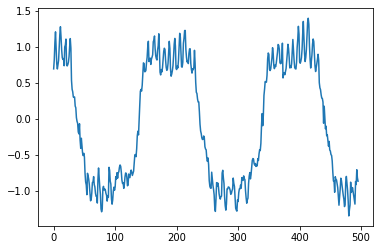

In [76]:
# Load data
data = import_data(data_path=PATH, shape=SHAPE)
# Split and scale data
x_train, x_val, x_test = scale_list(train_val_test_split(data))

x_train = split(x_train, width=15, stride=1)
print('Train set shape \t', x_train.shape)

x_val = split(x_val, width=15, stride=1)
print('Validation set shape \t', x_val.shape)

#x_test = split(x_test, width=15, stride=5)
#print('Test set shape \t', x_test.shape)


plt.plot(data[3,:,2])

In [79]:
def TrainData(x_train, x_val, model):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
    
    input_train = x_train[:,:14,:].reshape(x_train.shape[0], 14, 3, 1)
    output_train = x_train[:,14,:].reshape(x_train.shape[0], 1, 3, 1)
    
    input_val = x_val[:,:14,:].reshape(x_val.shape[0], 14, 3, 1)
    output_val = x_val[:,14,:].reshape(x_val.shape[0], 1, 3, 1)
    history = model.fit(input_train, output_train,
                    epochs= 250,
                    steps_per_epoch = 100,
                    shuffle = True,
                    batch_size=None,
                    validation_data=(input_val, output_val),
                    callbacks = [es],
                    validation_steps = 1
                   )
    return history

In [80]:
history = TrainData(x_train, x_val, autoencoder)

Train on 26992 samples, validate on 7712 samples
Epoch 1/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0412 - val_loss: 0.0419
Epoch 2/50
100/100 [==============================] - 0s 4ms/step - loss: 0.0407 - val_loss: 0.0416
Epoch 3/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0404 - val_loss: 0.0412
Epoch 4/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0401 - val_loss: 0.0408
Epoch 5/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0398 - val_loss: 0.0405
Epoch 6/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0395 - val_loss: 0.0403
Epoch 7/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0393 - val_loss: 0.0400
Epoch 8/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0390 - val_loss: 0.0398
Epoch 9/50
100/100 [==============================] - 0s 3ms/step - loss: 0.0389 - val_loss: 0.0396
Epoch 10/50
100/100 [==============================

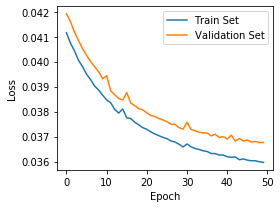

In [81]:
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(111)

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train Set', 'Validation Set'], loc='upper right')
plt.tight_layout()
plt.show()
#plt.savefig('history.png')

In [71]:
def show_predicted(track_index, var_index, savefig=False):
    predicted = test_track(data=x_test, model=autoencoder, track_index=track_index, frame_width=14)
    print(predicted.shape)


    fig = plt.figure(figsize=(18,6))
    plt.scatter(range(predicted.shape[0]), predicted[:,var_index], marker='.')
    plt.scatter(range(x_test.shape[1]), x_test[track_index,:,var_index], marker='+')
    plt.legend(('predicted', 'true'))
    if savefig:
        plt.savefig('dim{}.png'.format(INDEX))
        
    plt.grid(b = 150)
    plt.show()
    
    
    
show_predicted(track_index=3, var_index=0)

(99,)


IndexError: too many indices for array

<Figure size 1296x432 with 0 Axes>